# Проект: Анализ белого и красного сортов вина. Предсказание сорта вина по химическому составу и другим атрибутам

# Импортирование библиотек и их модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from sklearn import model_selection, metrics, ensemble, linear_model, preprocessing, manifold

In [2]:
import dask.delayed
import warnings
warnings.filterwarnings('ignore')

# Чтение данных с csv файла

In [3]:
wine = pd.read_csv('wine.csv', sep='\t')
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Анализ видов вина

## Соотношение данных:

In [4]:
print('Кол-во объектов красного вина: {}'.format(len(wine[wine['Type'] == 'red'])))
print('Кол-во объектов белого вина: {}'.format(len(wine[wine['Type'] == 'white'])))

Кол-во объектов красного вина: 1599
Кол-во объектов белого вина: 4898


#### *Количество экземпляров белого вина в 3 раза больше, чем красного, однако на методы предсказания, которые будут использованы это не повлияет.*

## Гистограмма оценок:

### Общая:

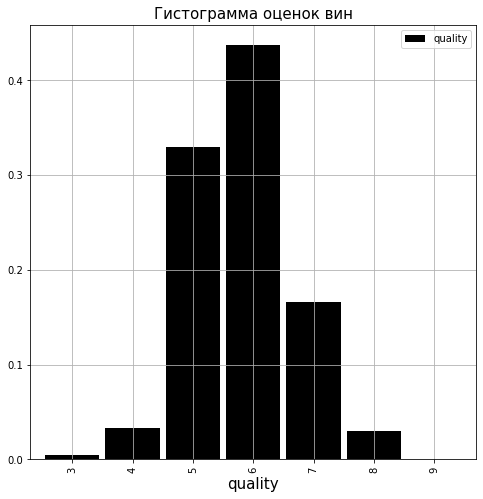

In [5]:
wine_quality = wine.groupby('quality')['quality'].agg(lambda x: float(len(x)) / float(len(wine)))
wine_quality.plot(kind='bar', color='black', width=0.9, figsize=(8, 8))
plt.grid(True)
plt.legend(fontsize=10, loc='upper right')
plt.xlabel('quality', fontsize=15)
plt.title('Гистограмма оценок вин', fontsize=15)
plt.show()

### Гистограммы красного и белого вин:

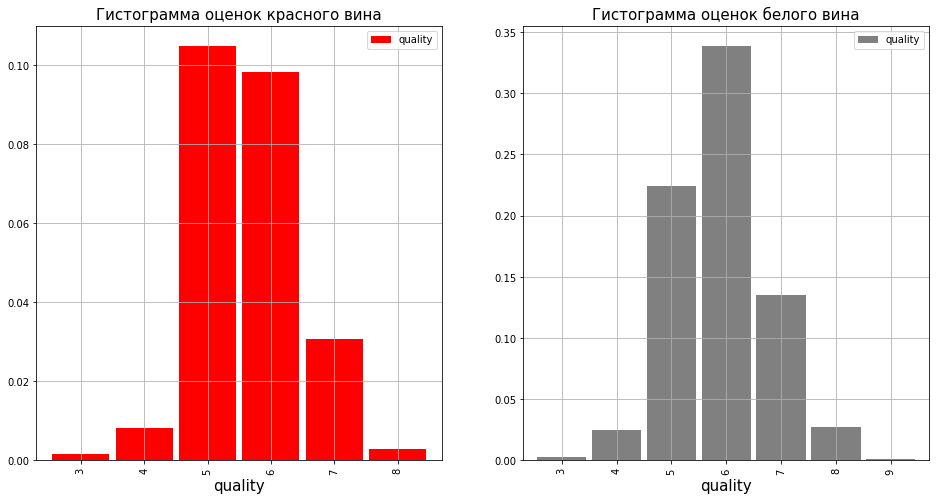

In [6]:
plt.subplot(121)
wine_red_quality = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x)) / float(len(wine)))
wine_red_quality.plot(kind='bar', color='red', width=0.9, figsize=(16, 8))
plt.grid(True)
plt.legend(fontsize=10, loc='upper right')
plt.xlabel('quality', fontsize=15)
plt.title('Гистограмма оценок красного вина', fontsize=15)

plt.subplot(122)
wine_white_quality = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x)) / float(len(wine)))
wine_white_quality.plot(kind='bar', color='grey', width=0.9, figsize=(16, 8))
plt.grid(True)
plt.legend(fontsize=10, loc='upper right')
plt.xlabel('quality', fontsize=15)
plt.title('Гистограмма оценок белого вина', fontsize=15)
plt.show()

### *Визуально видно, что средняя оценка белого вина больше, чем у красного. Проверим суждение коэффициентом Стьюдента.*

## Нулевая гипотеза - средние оценки за красное и белое вина одиноковые. Альтернативная гипотеза - средние оценки за красное и белое вина различаются. Коэффициент Альфа = 5%.

In [7]:
wine_red_quality_mean = wine[wine['Type'] == 'red']['quality'].tolist()
wine_white_quality_mean = wine[wine['Type'] == 'white']['quality'].tolist()

result = st.ttest_ind(wine_red_quality_mean, wine_white_quality_mean, equal_var=False)
print('p-value: {}'.format(result.pvalue))

p-value: 8.168348870049682e-24


### *p-value очень мало, а значит средние всё-таки различаются и у белого оно больше.*

## Зависимость других химических характеристик от оценки вина для красного и белого вин

In [8]:
features = ['Fixed acidity (g/l)', 'Volatile acidity (g/l)', 'Citric acid (g/l)', 'Residual sugar (g/l)', 'Chlorides (g/l)',
            'Free sulfur dioxide  (mg/l)', 'Total sulfur dioxide (mg/l)', 'Density (g/cm3)', 'pH', 'Sulphates (g/l)',
            'Alcohol (%)']

<Figure size 1440x1440 with 0 Axes>

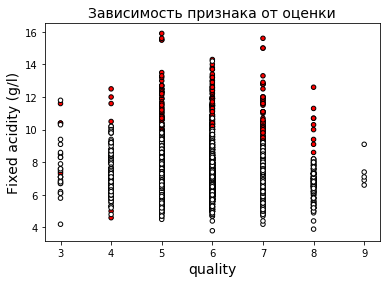

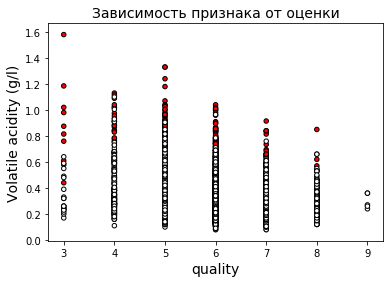

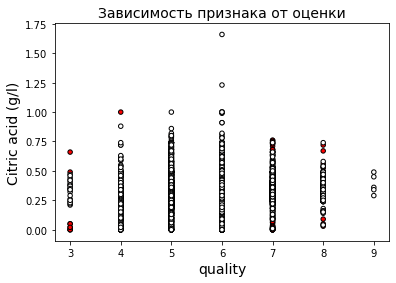

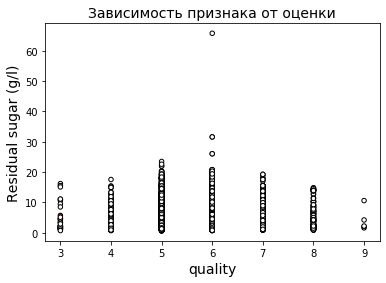

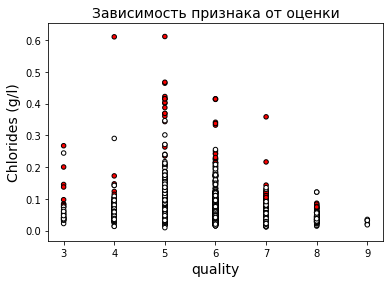

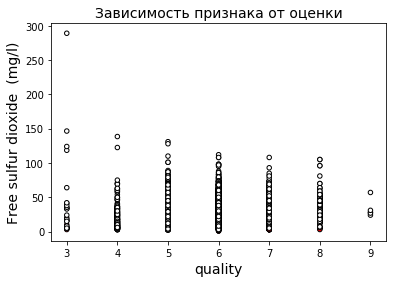

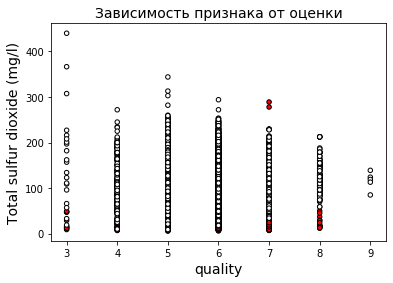

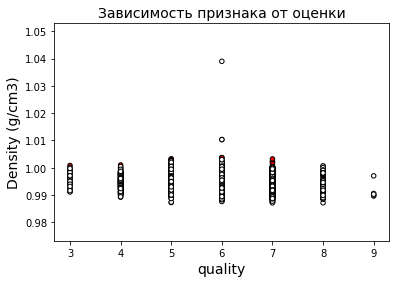

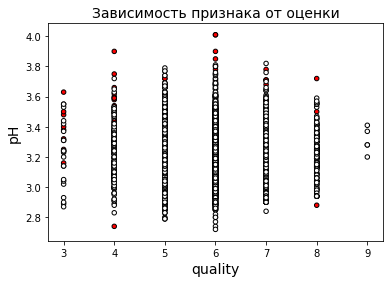

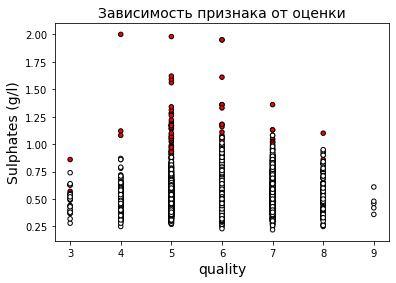

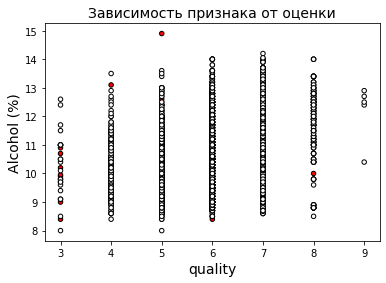

In [9]:
plt.figure(figsize = (20, 20))
for feature in ['Fixed acidity (g/l)', 'Volatile acidity (g/l)', 'Citric acid (g/l)', 'Residual sugar (g/l)', 'Chlorides (g/l)',
                'Free sulfur dioxide  (mg/l)', 'Total sulfur dioxide (mg/l)', 'Density (g/cm3)', 'pH', 'Sulphates (g/l)',
                'Alcohol (%)']:
    wine.plot(x='quality', y=feature, kind='scatter', color=wine['Type'], edgecolors='black')
    plt.xlabel('quality', fontsize=14)
    plt.ylabel(feature, fontsize=14)
    plt.title('Зависимость признака от оценки', fontsize=14)
plt.show()

### *Как можно видеть сложно однозначно разделить два класса обычными методами классификации. Лучше всего прибегнуть к композиции алгоритмов*

## Попарная зависимость признаков друг от друга для классов(уберем классы, которые на графиках плохо разделяют классы)

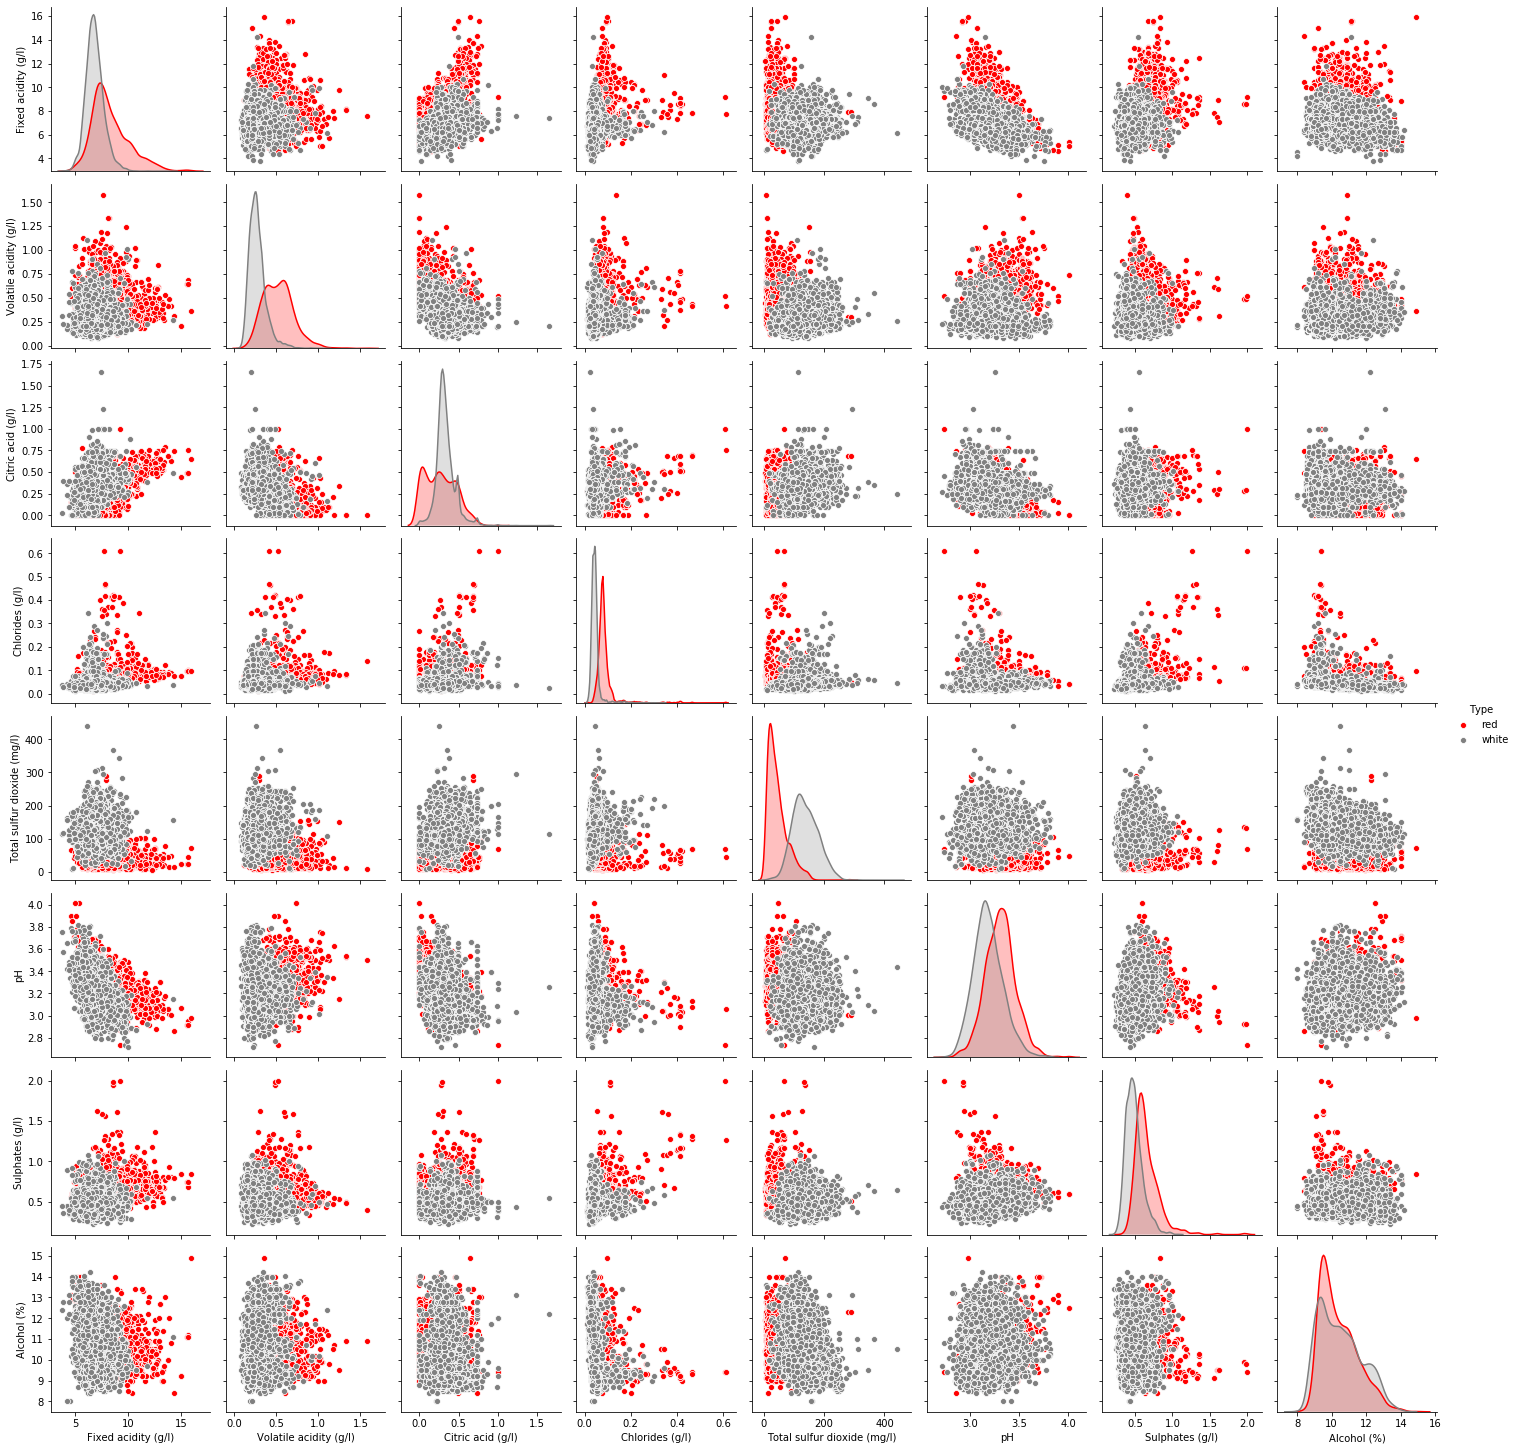

In [10]:
sns.pairplot(wine.drop(['quality', 'Free sulfur dioxide  (mg/l)', 'Residual sugar (g/l)', 'Density (g/cm3)'], axis = 1),
             hue = 'Type', palette = {'red' : 'red', 'white' : 'grey'})
plt.show()

## Корреляция признаков друг от друга

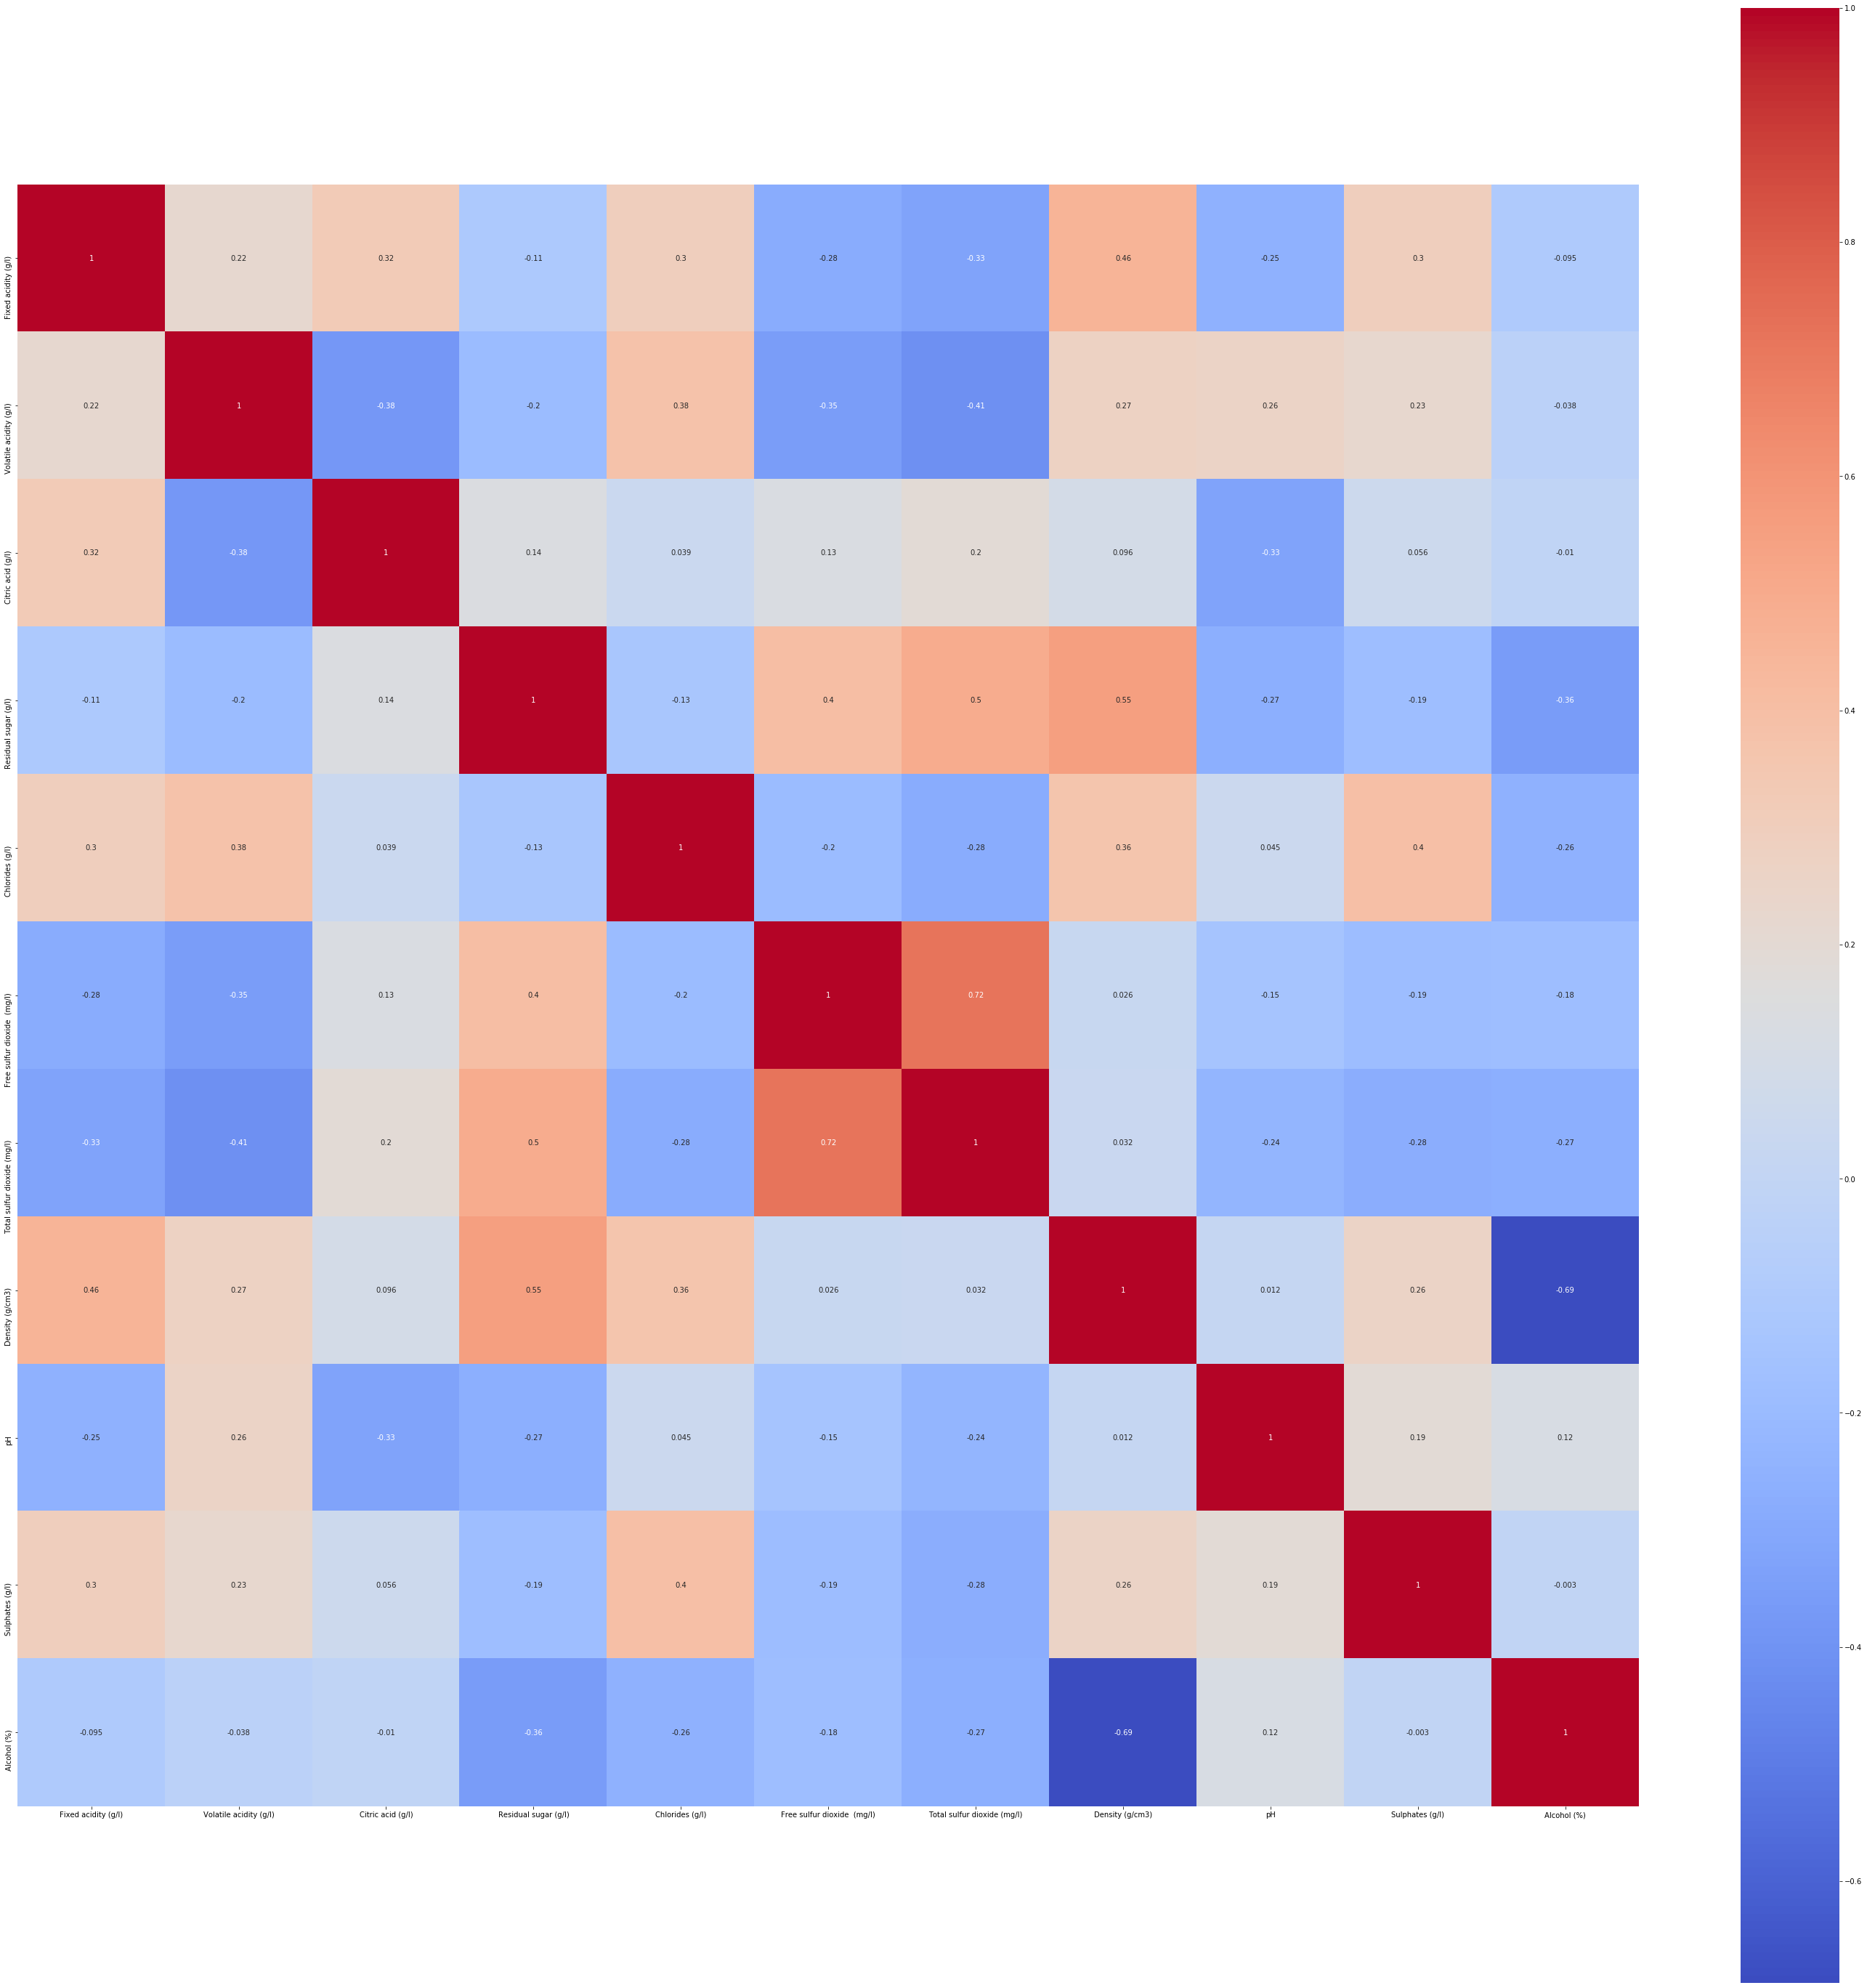

In [11]:
corr_features = ['Fixed acidity (g/l)', 'Volatile acidity (g/l)', 'Citric acid (g/l)', 'Residual sugar (g/l)','Chlorides (g/l)',
                 'Free sulfur dioxide  (mg/l)', 'Total sulfur dioxide (mg/l)', 'Density (g/cm3)', 'pH', 'Sulphates (g/l)',
                 'Alcohol (%)']
plt.figure(figsize = (50, 50))
sns.heatmap(wine[corr_features].corr(), square = True, cmap = 'coolwarm', annot = True)
plt.show()

### *Как можно видеть, все признаки довольно плохо коррелируют друг с другом, а значит и линейная зависимость минимальная, это хорошо поскольку все признаки можно считать линейно независимыми.*

## Графики разброса значений столбцов

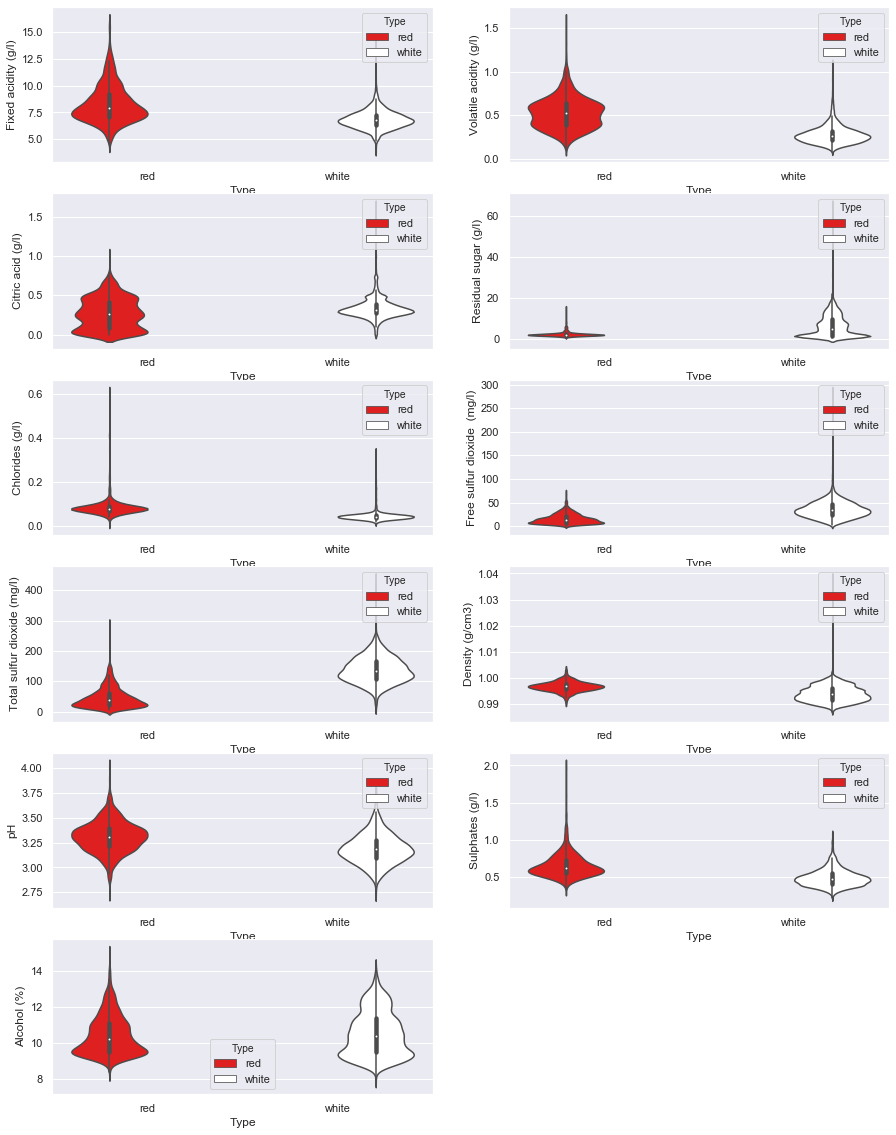

In [12]:
plt.figure(figsize = (15, 20))
subplot = 0
sns.set(style = 'darkgrid')
for feature in corr_features:
    subplot += 1
    plt.subplot(6, 2, subplot)
    sns.violinplot(y = feature, x = 'Type', data = wine, hue = 'Type', palette = {'red' : 'red', 'white': 'white'})

### *Можно заметить, что для большинства признаков медианные значения различаются, соответственно в совокупности признаков можно достаточно с неплохой точностью различать типы вин.*

## Визуализация при помощи метода понижения размерности(Для всех признаков на 2D плоскости)

In [13]:
wine.columns

Index(['Type', 'Fixed acidity (g/l)', 'Volatile acidity (g/l)',
       'Citric acid (g/l)', 'Residual sugar (g/l)', 'Chlorides (g/l)',
       'Free sulfur dioxide  (mg/l)', 'Total sulfur dioxide (mg/l)',
       'Density (g/cm3)', 'pH', 'Sulphates (g/l)', 'Alcohol (%)', 'quality'],
      dtype='object')

In [14]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 1)
tsne_vis = tsne.fit_transform(wine.drop(['Type', 'quality'], axis = 1), wine[['Type']])

In [15]:
tsne_vis = tsne_vis.tolist()
tsne_vis = pd.DataFrame(data = tsne_vis, columns = ['0', '1'])
tsne_vis.head()

,0,1
0,-99.931374,2.355047
1,-60.752625,7.672671
2,-76.156052,-2.375536
3,-70.597450,-1.506603
4,-99.931366,2.355113


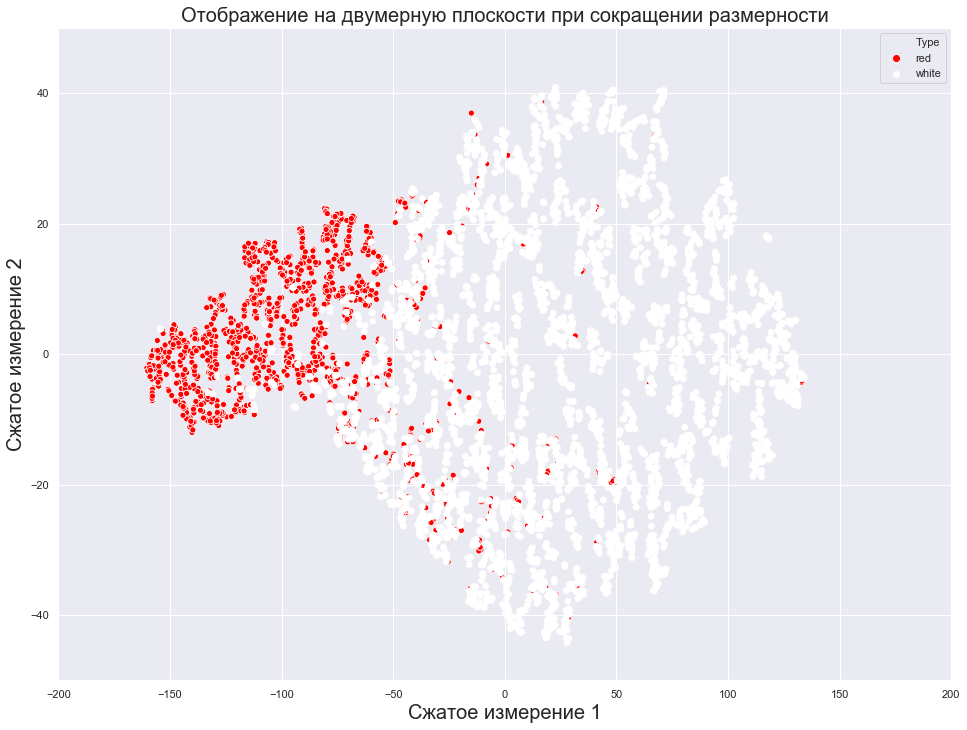

In [16]:
plt.figure(figsize = (16, 12))
sns.set(style = 'darkgrid')
sns.scatterplot(x = tsne_vis['0'], y = tsne_vis['1'], hue = wine['Type'], palette = {'red' : 'red', 'white' : 'white'})
plt.xlim(-200, 200)
plt.ylim(-50, 50)
plt.xlabel('Сжатое измерение 1', fontsize = 20)
plt.ylabel('Сжатое измерение 2', fontsize = 20)
plt.title('Отображение на двумерную плоскости при сокращении размерности', fontsize = 20)
plt.show()

### *Отчетливо видно, что два класса легко разделимы даже на сжатой(с потерей информации) 2D плоскости. Вероятнее всего классификаторы машинного обучения справятся без преобразования признаков.*

# Построение модели машинного обучения

### Переопределение меток из категориального значения на {+1, -1}:

In [17]:
wine['Type'] = wine['Type'].apply(lambda x: -1 if x == 'white' else 1)
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Признаки:

In [18]:
X = wine.drop(['Type', 'quality'], axis=1)
X.head()

,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%)
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Метки:

In [19]:
Y = wine[['Type']]
Y.head()

,Type
0,1
1,1
2,1
3,1
4,1


### *Данные нормализовать не будем, поскольку все величины примерно одного порядка(размерность величин уже отнормализовала параметры).*

### Разделение данных на обучающую и тестовую выборки:

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=10)

# Модель 1: Случайный лес

## Оценка наилучшего разделения между тренировочными и тестовыми данными(max_depth = 2):

In [21]:
forest_split = ensemble.RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1)

In [22]:
train_sizes_abs, train_scores, test_scores = model_selection.learning_curve(forest_split, X, Y, 
                                                                            train_sizes=np.arange(0.1, 1, 0.1),
                                                                            cv=5, scoring='accuracy')

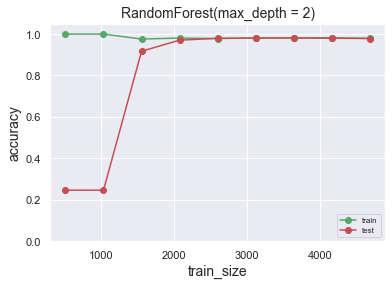

In [23]:
plt.grid(True)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), 'g-', marker='o', label='train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), 'r-', marker='o', label='test')
plt.title('RandomForest(max_depth = 2)', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('train_size', fontsize=14)
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right', fontsize=8)
plt.show()

## Оценка наилучшего разделения между тренировочными и тестовыми данными(max_depth = 25):

In [24]:
forest_split = ensemble.RandomForestClassifier(n_estimators=100, max_depth=25, random_state=1)

In [25]:
train_sizes_abs, train_scores, test_scores = model_selection.learning_curve(forest_split, X, Y,
                                                                            train_sizes=np.arange(0.1, 1, 0.1),
                                                                            cv=5, scoring='accuracy')

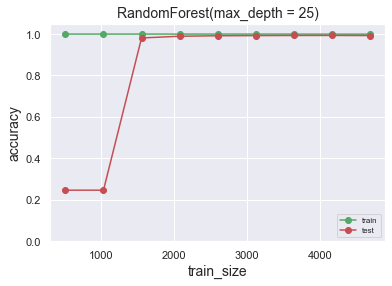

In [26]:
plt.grid(True)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), 'g-', marker='o', label='train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), 'r-', marker='o', label='test')
plt.title('RandomForest(max_depth = 25)', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('train_size', fontsize=14)
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right', fontsize=8)
plt.show()

### *Как можно видеть в случае максимально глубины деревьев = 25, алгоритм точнее, ну действительно, алгоритм решающих деревьев нацелен на усреднение переобученных деревьев, а чтобы их переобучить глубина должна быть как можно больше.*

## Зависимость точности модели от количества деревьев:

In [27]:
number_trees = np.arange(1, 100, 5)
number_trees

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])

In [28]:
accuracy = []
for number_tree in number_trees:
    forest = ensemble.RandomForestClassifier(n_estimators=int(number_tree), random_state=2)
    score = model_selection.cross_val_score(forest, X, Y, scoring='accuracy')
    accuracy.append(score)

In [29]:
accuracy = np.asmatrix(accuracy)

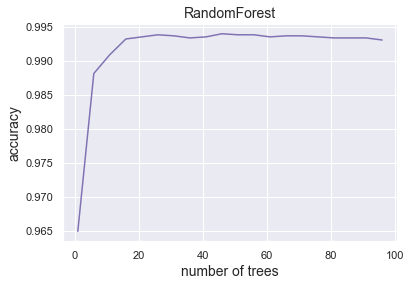

In [30]:
plt.plot(number_trees, accuracy.mean(axis=1), label='RandomForest', color='m')
plt.grid(True)
plt.title('RandomForest', fontsize=14)
plt.xlabel('number of trees', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.show()

### *Из графиков зависимостей видно, что алгоритм очень хорошо описываев классификацию вин и при этом известно, что оно не переобучается, поскольку ошибка на тестовой выборка примерно такая же как и на обучающей.*

## Анализ параметров случайного леса, для отслеживания лучшей модели:

In [31]:
regr_params = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5, random_state=3)
regr_params.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [32]:
parameters_grid = {
    'max_features': np.arange(3, 11, 1),
    'max_samples':  np.linspace(3800, 4400, 20, dtype='int'),
}

In [33]:
cv = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=4)

In [34]:
grid_cv = model_selection.GridSearchCV(regr_params, parameters_grid, cv=cv, scoring='accuracy')

In [35]:
grid_cv.fit(X, Y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=4, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min...
                                              oob_score=False, random_state=3,
                                              verbose=0, warm_start=False),
             iid='depre

In [36]:
print('best accuracy: {}'.format(grid_cv.best_score_))
print(grid_cv.best_params_)

best accuracy: 0.990923076923077
{'max_features': 5, 'max_samples': 4400}


# Создание лучшей модели

In [37]:
forest = ensemble.RandomForestClassifier(
    n_estimators=100, max_depth=25, max_features=5, max_samples=4400, n_jobs=-1, random_state=20)

### Обучение лучшей модели RandomForestClassifier:

In [38]:
forest.fit(X_train, y_train)
predictions1 = forest.predict(X_test)

## Метрики оценки лучшей модели RandomForestClassifier:

### accuracy

In [39]:
print('accuracy: {: .3f}'.format(metrics.accuracy_score(y_test, predictions1)))

accuracy:  0.992


### confusion - matrix

In [40]:
matrix = metrics.confusion_matrix(y_test, predictions1)
print(matrix)

[[979   2]
 [  8 311]]


### precision

In [41]:
print('precision class -1: {: .3f}'.format(
    metrics.precision_score(y_test, predictions1, pos_label=-1)))  # -1

precision class -1:  0.992


In [42]:
print('precision class +1: {: .3f}'.format(
    metrics.precision_score(y_test, predictions1, pos_label=+1)))  # +1

precision class +1:  0.994


### recall

In [43]:
print('recall class -1: {: .3f}'.format(metrics.recall_score(y_test, predictions1, pos_label=-1)))  # -1

recall class -1:  0.998


In [44]:
print('recall class +1: {: .3f}'.format(metrics.recall_score(y_test, predictions1, pos_label=+1)))  # +1

recall class +1:  0.975


### F1 - score

In [45]:
print('F1 - score, class -1: {: .3f}'.format(metrics.f1_score(y_test, predictions1, pos_label=-1)))  # -1

F1 - score, class -1:  0.995


In [46]:
print('F1 - score, class +1: {: .3f}'.format(metrics.f1_score(y_test, predictions1, pos_label=+1)))  # +1

F1 - score, class +1:  0.984


### classification report

In [47]:
print(metrics.classification_report(y_test, predictions1))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       981
           1       0.99      0.97      0.98       319

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



## Влияение коэффициентов на предсказание модели RandomForestClassifier:

In [48]:
importances = pd.DataFrame(zip(X_train.columns, forest.feature_importances_))
importances.columns = ['feature_name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature_name,importance
6,Total sulfur dioxide (mg/l),0.396420
4,Chlorides (g/l),0.318701
1,Volatile acidity (g/l),0.096296
7,Density (g/cm3),0.043619
5,Free sulfur dioxide (mg/l),0.031951
9,Sulphates (g/l),0.031437
3,Residual sugar (g/l),0.027372
0,Fixed acidity (g/l),0.023803
8,pH,0.015967
2,Citric acid (g/l),0.008328


### *Модель очень точная, её вполне можно использовать для предсказаний. Посмотрим может ли GradientBoostingClassifier быть ещё точнее.*

# Модель 2: GradientBoostingClassifier

## Оценка наилучшего разделения между тренировочными и тестовыми данными(max_depth = 2):

In [49]:
gradient_split = ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=1)

In [50]:
train_sizes_abs, train_scores, test_scores = model_selection.learning_curve(forest_split, X, Y,
                                                                            train_sizes=np.arange(0.1, 1, 0.1),
                                                                            cv=5, scoring='accuracy')

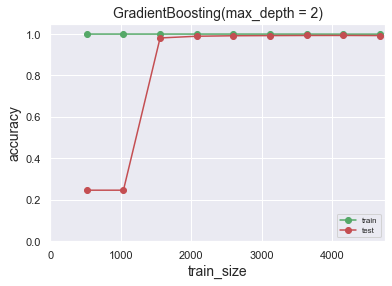

In [51]:
plt.grid(True)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), 'g-', marker='o', label='train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), 'r-', marker='o', label='test')
plt.title('GradientBoosting(max_depth = 2)', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('train_size', fontsize=14)
plt.xlim((0, 4750))
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right', fontsize=8)
plt.show()

## Оценка наилучшего разделения между тренировочными и тестовыми данными(max_depth = 25):

In [52]:
gradient_split = ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=1)

In [53]:
train_sizes_abs, train_scores, test_scores = model_selection.learning_curve(gradient_split, X, Y,
                                                                            train_sizes=np.arange(0.1, 1, 0.1),
                                                                            cv=5, scoring='accuracy')

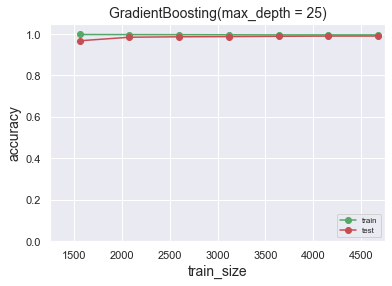

In [54]:
plt.grid(True)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), 'g-', marker='o', label='train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), 'r-', marker='o', label='test')
plt.title('GradientBoosting(max_depth = 25)', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('train_size', fontsize=14)
plt.xlim((1250, 4750))
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right', fontsize=8)
plt.show()

### *Нетрудно заметить, что модели приближают значения к максимальной точности примерно одинаково по отношению к разбиению данных. То есть мало что зависит от глубины, ну действительно градиентный бустинг и работает на основе корректировки предыдущих алгоритмов, поэтому алгоритмы не обязательно должны быть сложными. Будем использовать max_depth = 10.*

## Зависимость точности модели от количества деревьев:

In [55]:
number_trees = np.arange(1, 100, 5)
number_trees

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])

In [56]:
accuracy = []
for number_tree in number_trees:
    forest = ensemble.GradientBoostingClassifier(n_estimators=int(number_tree), random_state=2)
    score = model_selection.cross_val_score(forest, X, Y, scoring='accuracy')
    accuracy.append(score)

In [57]:
accuracy = np.asmatrix(accuracy)

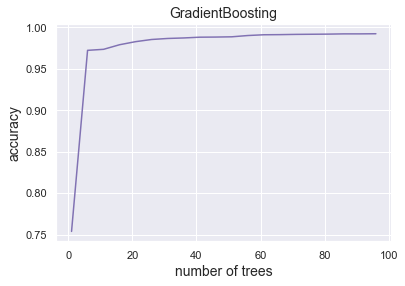

In [58]:
plt.plot(number_trees, accuracy.mean(axis=1), label='GradientBoosting', color='m')
plt.grid(True)
plt.title('GradientBoosting', fontsize=14)
plt.xlabel('number of trees', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.show()

### *Как можно видеть, Градиентный бустинг именно приближается к ассимптоте в 1.00, что близко к истине, ведь Градиентный бустинг улучшает каждый предыдущий алгоритм. Количество деревьев нужно использовать как можно больше.*

## Анализ параметров Градиентного бустинга, для отслеживания лучшей модели:

In [59]:
regr_params = ensemble.GradientBoostingClassifier(n_estimators=10, max_depth=5, random_state=3)
regr_params.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [60]:
parameters_grid = {
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'max_features': np.arange(3, 8, 1),
}

In [61]:
cv = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=4)

In [62]:
grid_cv = model_selection.GridSearchCV(regr_params, parameters_grid, cv=cv, scoring='accuracy')

In [63]:
grid_cv.fit(X, Y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=4, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=5,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1...
                                                  n_iter_no_change=None,
                                                  presort='deprecated',
                                                

In [64]:
print('best accuracy: {}'.format(grid_cv.best_score_))
print(grid_cv.best_params_)

best accuracy: 0.9886153846153846
{'learning_rate': 0.09, 'max_features': 7}


## Обучение лучшей модели Градиентного Бустинга:

In [65]:
gradient = ensemble.GradientBoostingClassifier(
    n_estimators=500, max_depth=10, learning_rate=0.09, max_features=7, random_state=10)

In [66]:
gradient.fit(X_train, y_train)
predictions2 = gradient.predict(X_test)

## Метрики оценки лучшей модели GradientBoostingClassifier:

### accuracy

In [67]:
print('accuracy: {: .3f}'.format(metrics.accuracy_score(y_test, predictions2)))

accuracy:  0.992


### confusion - matrix

In [68]:
matrix = metrics.confusion_matrix(y_test, predictions2)
print(matrix)

[[980   1]
 [ 10 309]]


### precision

In [69]:
print('precision class -1: {: .3f}'.format(metrics.precision_score(y_test, predictions2, pos_label=-1)))  # -1

precision class -1:  0.990


In [70]:
print('precision class +1: {: .3f}'.format(metrics.precision_score(y_test, predictions2, pos_label=+1)))  # +1

precision class +1:  0.997


### recall

In [71]:
print('recall class -1: {: .3f}'.format(metrics.recall_score(y_test, predictions2, pos_label=-1)))  # -1

recall class -1:  0.999


In [72]:
print('recall class +1: {: .3f}'.format(metrics.recall_score(y_test, predictions2, pos_label=+1)))  # +1

recall class +1:  0.969


### F1 - score

In [73]:
print('F1 - score, class -1: {: .3f}'.format(metrics.f1_score(y_test, predictions2, pos_label=-1)))  # -1

F1 - score, class -1:  0.994


In [74]:
print('F1 - score, class +1: {: .3f}'.format(metrics.f1_score(y_test, predictions2, pos_label=+1)))  # +1

F1 - score, class +1:  0.983


### classification - report

In [75]:
print(metrics.classification_report(y_test, predictions2))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       981
           1       1.00      0.97      0.98       319

    accuracy                           0.99      1300
   macro avg       0.99      0.98      0.99      1300
weighted avg       0.99      0.99      0.99      1300



## Влияение коэффициентов на предсказание модели GradientBoostingClassifier:

In [76]:
importances = pd.DataFrame(zip(X_train.columns, gradient.feature_importances_))
importances.columns = ['feature_name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature_name,importance
6,Total sulfur dioxide (mg/l),0.644439
4,Chlorides (g/l),0.161759
1,Volatile acidity (g/l),0.071682
7,Density (g/cm3),0.043519
8,pH,0.019124
9,Sulphates (g/l),0.018472
0,Fixed acidity (g/l),0.015869
3,Residual sugar (g/l),0.014227
10,Alcohol (%),0.004763
2,Citric acid (g/l),0.003377


## Сравнение classification - report моделей:

## RandomForest:

In [77]:
print(metrics.classification_report(y_test, predictions1, digits=4))

              precision    recall  f1-score   support

          -1     0.9919    0.9980    0.9949       981
           1     0.9936    0.9749    0.9842       319

    accuracy                         0.9923      1300
   macro avg     0.9928    0.9864    0.9895      1300
weighted avg     0.9923    0.9923    0.9923      1300



## GradientBoosing:

In [78]:
print(metrics.classification_report(y_test, predictions2, digits=4))

              precision    recall  f1-score   support

          -1     0.9899    0.9990    0.9944       981
           1     0.9968    0.9687    0.9825       319

    accuracy                         0.9915      1300
   macro avg     0.9933    0.9838    0.9885      1300
weighted avg     0.9916    0.9915    0.9915      1300



# **Обе модели: RandomForestClassifier, GradientBoostingClassifier - очень с большой точностью описывают исходную классификацию данных. Модели найдены.**